# Damage Exchange Analyzer

for EVE online (www.eveonline.com) using game log files stored on local machine

crafted by Khlaa Sor of KS Endeavours (*work in progress, improvement suggestions welcome*)

In [96]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid") #  setting the visualization style
sns.set_context("notebook", font_scale=.9) # setting the visualization scale
import numpy as np
%matplotlib inline

In [97]:
# function to produce a list of explode values for pie charts
def pie_exploder(vals):
    """
    :vals: a list of values to be represented by the pie vedges, sorted in descending order for best results
    :return: a list of explode values for pie charts to only explode very narrow vedges
    :required: numpy
    """
    e = 0.01 # default explode value for all vedges
    explode = np.zeros(len(vals)) + e # generating default list of uniform explode values with numpy
    i = 0
    for val in vals:
        if val / sum(vals) < 0.03: #  tiny vedge qualification treshold (fraction of the total sum)
            explode[i] = e #  in the first run, default explode value is applied unchanged
            e += .09 #  incrementing the explode value starting from the second encountered tiny vedge
        i += 1

    return explode

## 1. Data selection and acquisition.

In [98]:
# Gamelogs directory path - unique for each user. 
w_dir = input('Gamelogs directory path: ').replace('\\', '/') + '/'
# print(w_dir)

# Building the list of log files potentially suitable for analysis
log_files = []
with os.scandir(w_dir) as all_files:
    for entry in all_files:
        if entry.stat().st_size > 512: # excluding very small files
            log_files.append(entry.name)

# Sorting the list of log files from newest down
log_files.sort(reverse=True)

# Looking for certain kind of targets
entity = input('Entity to search for (any part of name, Enter to skip): ')

if entity:
    traced = [] # list to hold file names where target of interest was detected
    for entry in log_files:
        path = w_dir + entry
        with open(path, encoding='utf-8') as file:
            if entity in file.read():
                traced.append(entry)

    if traced:
        log_files = traced
        print(f'{entity} traced in the following op logs ({len(log_files)}):')
    else:
        print('No traces detected.')    
else: 
    print('Not specified')
    print(f'Acquired the following log files ({len(log_files)}):')

Gamelogs directory path:  C:\Users\Maksim Mislavskii\Documents\EVE\logs\Gamelogs
Entity to search for (any part of name, Enter to skip):  Devout Fanatic


Devout Fanatic traced in the following op logs (8):


In [99]:
for entry in log_files:
    print(entry)

20210513_155125_91278319.txt
20210512_074031_91278319.txt
20210511_154834_91278319.txt
20210510_125105_91278319.txt
20210510_062440_91278319.txt
20210509_115718_91278319.txt
20210507_112528_91278319.txt
20210507_041841_91278319.txt


In [113]:
# Selecting the file to analyse
file_name = input('Log file name to analyze, Enter for latest: ')
if not file_name:
    file_name = log_files[0] # defaulting to the latest file
print(file_name)
# Constructing the log file path
file_path = w_dir + file_name

Log file name to analyze, Enter for latest:  


20210513_155125_91278319.txt


In [114]:
# reading the file and getting rid of the tags in the process
with open(file_path) as log_file:
    lines = [re.sub('<.+?>', '', #  replacing each tag with empty string
                    line.strip() 
                   ) for line in log_file.readlines()]
if lines:
    print(f'Log data loaded: {len(lines)} entries')

Log data loaded: 1575 entries


In [115]:
# printing the log out line by line (commented out to avoid offending GitHub users with a wall of text)
#for line in lines:
#   print(line)
# (can change the code to print nice clearly readable log with no tags into a file)

## 2. Preparing the data for analysis with Pandas.

In [116]:
# Getting a list of all combat related entries:
combat = [line.strip('[ ').replace(' ]', ''  # cleaning the timestamps
                                  ) for line in lines if '(combat)' in line]

if entity:  # with optional filtering for entity searched for in the log files
    specific = input('Filter for selected kind of targets (1/Enter):') 
    if specific:
        print(f'Filtering for {entity}')
        combat = [line for line in combat if entity in line]
    else:
        print('No filtering applied.')

# and preparing it for dataframing by turning each entry into a row of cells,
# installing column separators '-' and performing the split
combat = [entry.replace('(combat)', '-')  # replacing '(combat)' with '-' to use as a column separator
          .replace(' to ', ' - to - ')
          .replace(' from ', ' - from - ')
          .split(' - ') for entry in combat]

# Getting a list of damage-exchange entries by filtering out entries missing hit quality tokens
tokens = ['Hits', 'Wrecks', 'Grazes', 'Glances Off', 'Penetrates', 'Smashes']
hits = [entry for entry in combat if entry[-1] in tokens]

# inserting 'Unknown' for missing enemy weapon data
for entry in hits:
    if len(entry) != 6:
        entry.insert(-1, 'Unknown')

# Creating the damage exchange dataframe
columns = ['Time', 'Damage', 'Direction', 'Entity', 'Weapon', 'Token']
hits_df =pd.DataFrame(data=hits, columns=columns)
hits_df.Damage = hits_df.Damage.astype('int')  # Casting the damage scores to integer

Filter for selected kind of targets (1/Enter): 


No filtering applied.


In [117]:
hits_df.describe(include='all')

,Time,Damage,Direction,Entity,Weapon,Token
count,1063,1063.000000,1063,1063,1063,1063
unique,569,NaN,2,11,9,6
top,2021.05.13 17:05:55,NaN,to,EoM Devout Fanatic,Hammerhead II,Hits
freq,6,NaN,981,218,500,408
mean,NaN,198.063970,NaN,NaN,NaN,NaN
std,NaN,95.235379,NaN,NaN,NaN,NaN
min,NaN,0.000000,NaN,NaN,NaN,NaN
25%,NaN,136.000000,NaN,NaN,NaN,NaN
50%,NaN,189.000000,NaN,NaN,NaN,NaN
75%,NaN,244.000000,NaN,NaN,NaN,NaN


## 3. Analysing the data and displaying results

### 3.1. Summary Stats

In [118]:
# Dealt damage
dealt_df = hits_df.loc[hits_df.Direction == 'to']
targets = dealt_df.Entity.unique().tolist() 
print(f'Damage dealt to {len(targets)} kinds of targets:')
for target in targets:
    print(f' - {target}')
print()
weapons = dealt_df.Weapon.unique().tolist()
print(f'with {len(weapons)} types of weapon systems:')
for weapon in weapons:
    print(f' - {weapon}')
print()

# Incoming damage
incoming_df = hits_df.loc[hits_df.Direction == 'from']
enemies = incoming_df.Entity.unique().tolist() 
print(f'Damage taken from {len(enemies)} kinds of enemies:')
for enemy in enemies:
        print(f' - {enemy}')
print()
enemy_weapons = incoming_df.Weapon.unique().tolist()
print(f'with {len(enemy_weapons)} types of weapon systems:')
for enemy_weapon in enemy_weapons:
    print(f' - {enemy_weapon}')
print()

Damage dealt to 11 kinds of targets:
 - EoM Stasis Webber Tower
 - EoM Warp Disruptor Tower
 - EoM Black Dagger
 - EoM Holy Sanctifier
 - EoM Devout Fanatic
 - EoM Hoplokrisma
 - EoM Holy Purger
 - EoM Holy Binder
 - EoM Zealous Sword
 - EoM Atoning Warrior
 - Vulnerable EoM Rogue Capital Shipyard

with 4 types of weapon systems:
 - Vespa II
 - Hammerhead II
 - Inferno Fury Light Missile
 - Scourge Fury Light Missile

Damage taken from 7 kinds of enemies:
 - EoM Black Dagger
 - EoM Hoplokrisma
 - EoM Devout Fanatic
 - EoM Zealous Sword
 - EoM Holy Sanctifier
 - EoM Holy Purger
 - EoM Atoning Warrior

with 5 types of weapon systems:
 - Unknown
 - Mjolnir Light Missile
 - Mjolnir Cruise Missile
 - Mjolnir Heavy Assault Missile
 - Scourge Heavy Assault Missile



#### 3.1.1. Dealt Damage

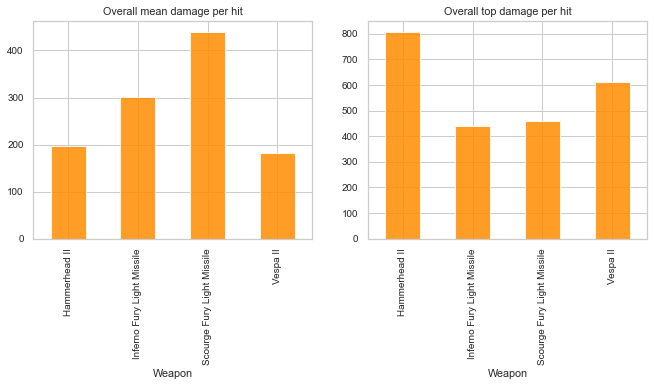

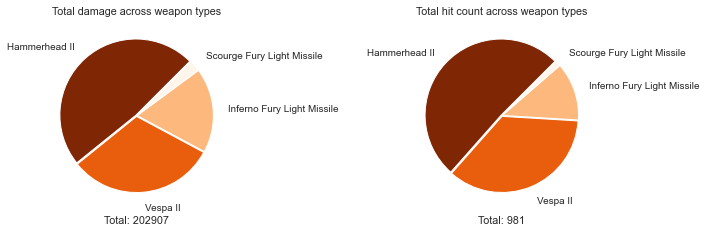

In [119]:
if weapons:
    # data for plotting
    means_per_weapon = dealt_df.groupby(['Weapon']).Damage.mean()#.sort_values(ascending=False)
    tops_per_weapon = dealt_df.groupby(['Weapon']).Damage.max()#.sort_values(ascending=False)
    totals_per_weapon = dealt_df.groupby(['Weapon']).Damage.sum().sort_values(ascending=False)
    hits_per_weapon = dealt_df.Weapon.value_counts()

    #  barcharts of mean and top damage scores per weapon
    plt.figure(figsize=(11,4)) 

    plt.subplot(121)
    means_per_weapon.plot(
        kind='bar', ylabel='', title='Overall mean damage per hit', 
        color='darkorange', alpha=.85
    )

    plt.subplot(122)
    tops_per_weapon.plot(
        kind='bar', ylabel='', title='Overall top damage per hit', 
        color='darkorange', alpha=.85
    )

    plt.show()

    # piecharts of total damage and hit counts per weapon
    plt.figure(figsize=(12,3.5), facecolor='white') 
    plt.subplot(121,
               xlabel=f'Total: {sum(totals_per_weapon)}') #  plotting total damage per weapon
    totals_per_weapon.plot(
        kind='pie', title='Total damage across weapon types', ylabel='',
        # radius=1.1,
        labeldistance=1.2,
        cmap='Oranges_r',
        startangle = 45,
        explode = pie_exploder(totals_per_weapon)
    )
    plt.subplot(122,
                xlabel=f'Total: {sum(hits_per_weapon)}') #  plotting total number of hits per weapon
    hits_per_weapon.plot(
        kind='pie', title='Total hit count across weapon types', ylabel='',
        # radius=.9,
        labeldistance=1.2,
        cmap='Oranges_r',
        startangle = 45,
        explode = pie_exploder(hits_per_weapon)
    )
    plt.show()
    
else:
    print('No meaningful interactions to analyze.')

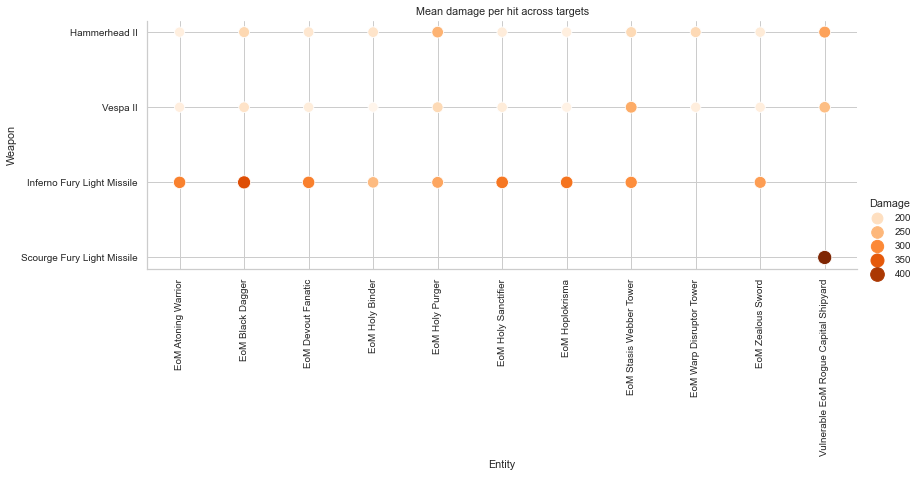

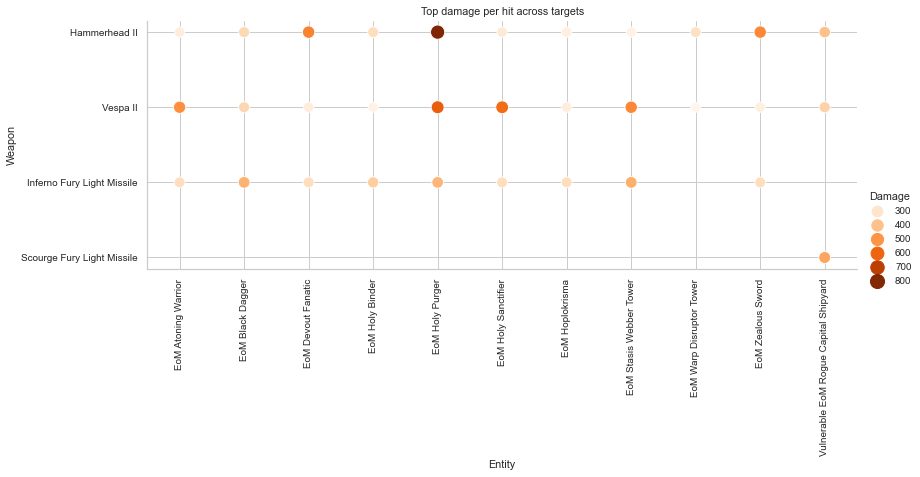

In [120]:
if weapons:
    # Plotting mean and top damage scores per weapon across all targets
    mean_damage_scores = pd.DataFrame(dealt_df.groupby(['Weapon', 'Entity']).Damage.mean()).sort_values(by='Entity')
    top_damage_scores = pd.DataFrame(dealt_df.groupby(['Weapon', 'Entity']).Damage.max()).sort_values(by='Entity')

    # Mean damage
    sns.relplot(y="Weapon", x="Entity", hue="Damage", size='Damage',
                data=mean_damage_scores, 
                height=4, aspect=3, 
                palette='Oranges', sizes=(100, 200)
        )
    plt.tick_params(axis='x', rotation=90)
    plt.title('Mean damage per hit across targets')
    plt.show()

    # Top damage
    sns.relplot(y="Weapon", x="Entity", hue="Damage", size='Damage',
                data=top_damage_scores, 
                height=4, aspect=3, 
                palette='Oranges', sizes=(100, 200)
        )
    plt.tick_params(axis='x', rotation=90)
    plt.title('Top damage per hit across targets')
    plt.show()

Hit quality distributions per weapon


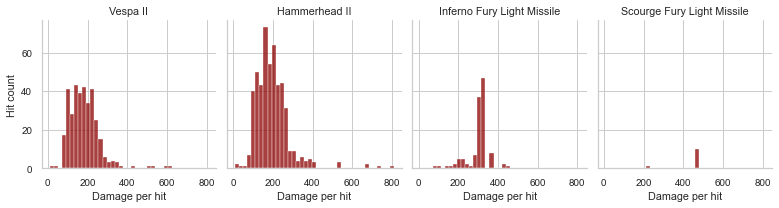

In [121]:
# Generating hit quality histograms with Seaborn
if weapons:
    print('Hit quality distributions per weapon')
    g = sns.displot(
        data=dealt_df, x="Damage", col="Weapon",
        col_wrap=5,
        height=3, aspect=.9, color='darkred'
    )
    g.set_axis_labels("Damage per hit", "Hit count")
    g.set_titles("{col_name}")
    plt.show()

**Alfa strike per weapon per target (top and bottom if much data):**

In [122]:
if weapons:
    if len(top_damage_scores) > 14:
        print(top_damage_scores.sort_values(by='Damage', ascending=False).head(7), end='\n'*2)
        print(top_damage_scores.sort_values(by='Damage', ascending=False).tail(7), end='\n'*2)
    else:
        print(top_damage_scores.sort_values(by='Damage', ascending=False), end='\n'*2)

                                       Damage
Weapon        Entity                         
Hammerhead II EoM Holy Purger             809
Vespa II      EoM Holy Purger             611
              EoM Holy Sanctifier         585
Hammerhead II EoM Devout Fanatic          534
              EoM Zealous Sword           526
Vespa II      EoM Stasis Webber Tower     525
              EoM Atoning Warrior         512

                                        Damage
Weapon        Entity                          
Vespa II      EoM Devout Fanatic           264
Hammerhead II EoM Atoning Warrior          262
Vespa II      EoM Zealous Sword            253
Hammerhead II EoM Hoplokrisma              252
Vespa II      EoM Holy Binder              241
Hammerhead II EoM Stasis Webber Tower      240
Vespa II      EoM Warp Disruptor Tower     222



#### 3.1.2. Incoming Damage

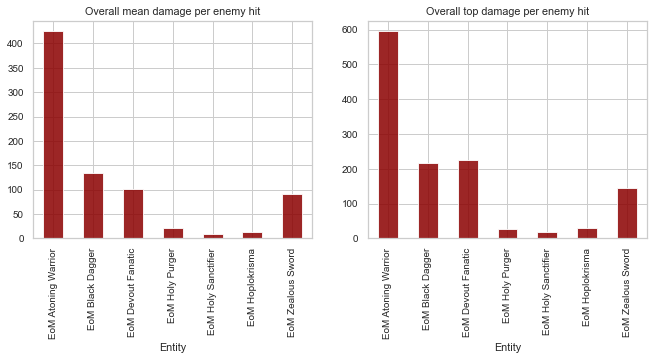

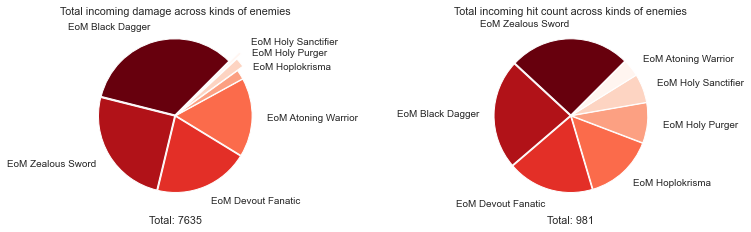

In [123]:
if enemies:
    # Data for plotting
    means_per_enemy = incoming_df.groupby(['Entity']).Damage.mean()
    tops_per_enemy = incoming_df.groupby(['Entity']).Damage.max()
    totals_per_enemy = incoming_df.groupby(['Entity']).Damage.sum().sort_values(ascending=False)
    hits_per_enemy = incoming_df.Entity.value_counts()
    
    #  barcharts of mean and top damage taken from each enemy
    plt.figure(figsize=(11,4)) 
    plt.subplot(121)
    means_per_enemy.plot(
        kind='bar', ylabel='', title='Overall mean damage per enemy hit', 
        color='darkred', alpha=.85
    )
    plt.subplot(122)
    tops_per_enemy.plot(
        kind='bar', ylabel='', title='Overall top damage per enemy hit', 
        color='darkred', alpha=.85
    )
    plt.show()
    
    # piecharts of total damage and hit counts from each enemy
    height = 3.5  # overall for the figure
    radius = 1  # for each pie
    if len(enemies) > 11: #  to provide more space for labels
        height = 5
        radius = .7
    
    plt.figure(figsize=(13,height), facecolor='white') 
    plt.subplot(121,
               xlabel=f'Total: {sum(totals_per_enemy)}')  # plotting total damage per weapon
    totals_per_enemy.plot(
        kind='pie', title='Total incoming damage across kinds of enemies', ylabel='',
        radius=radius,
        labeldistance=1.2,
        cmap='Reds_r',
        startangle = 45,
        explode = pie_exploder(totals_per_enemy)
    )
    plt.subplot(122,
                xlabel=f'Total: {sum(hits_per_weapon)}') #  plotting total number of hits per weapon
    hits_per_enemy.plot(
        kind='pie', title='Total incoming hit count across kinds of enemies', ylabel='',
        radius=radius,
        labeldistance=1.2,
        cmap='Reds_r',
        startangle = 45,
        explode = pie_exploder(hits_per_enemy)
    )
    plt.show()
    
else:
    print('No meaningful interactions to analyze.')

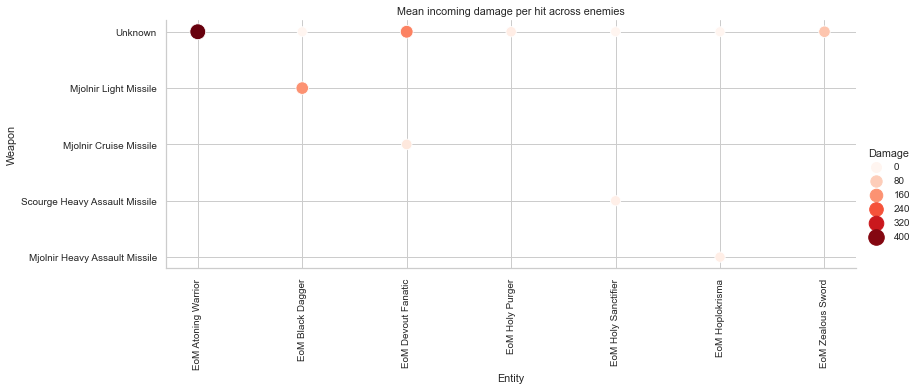

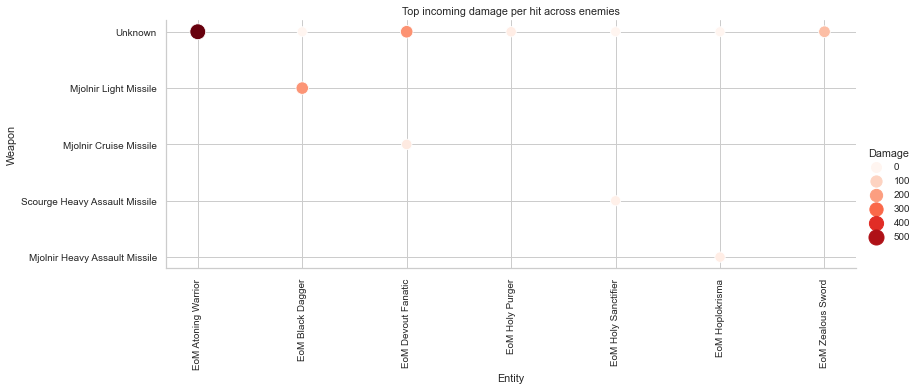

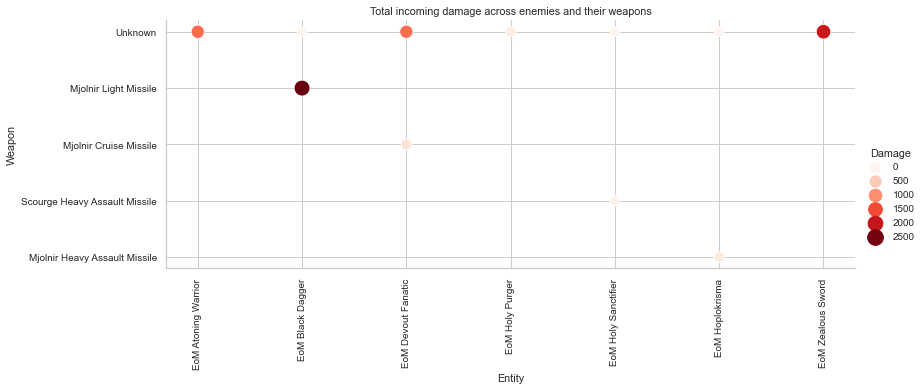

Enemy alfa strike per weapon per kind of enemy (top 11):
                                                   Damage
Weapon                        Entity                     
Unknown                       EoM Atoning Warrior     595
                              EoM Devout Fanatic      225
Mjolnir Light Missile         EoM Black Dagger        218
Unknown                       EoM Zealous Sword       144
Mjolnir Cruise Missile        EoM Devout Fanatic       39
Mjolnir Heavy Assault Missile EoM Hoplokrisma          30
Unknown                       EoM Holy Purger          28
Scourge Heavy Assault Missile EoM Holy Sanctifier      17
Unknown                       EoM Black Dagger          0
                              EoM Holy Sanctifier       0
                              EoM Hoplokrisma           0



In [124]:
if len(enemy_weapons) > 1:
    # Plotting mean and top incoming damage scores per enemy weapon across all kinds of enemies
    mean_damage_scores = pd.DataFrame(incoming_df.groupby(['Weapon', 'Entity']).Damage.mean()).sort_values(by='Entity')
    top_damage_scores = pd.DataFrame(incoming_df.groupby(['Weapon', 'Entity']).Damage.max()).sort_values(by='Entity')
    totals = pd.DataFrame(incoming_df.groupby(['Weapon', 'Entity']).Damage.sum()).sort_values(by='Entity')

    # Mean damage
    sns.relplot(y="Weapon", x="Entity", hue="Damage", size='Damage',
                data=mean_damage_scores, 
                height=4, aspect=3, 
                palette='Reds', sizes=(100, 250)
        )
    plt.tick_params(axis='x', rotation=90)
    plt.title('Mean incoming damage per hit across enemies')
    plt.show()

    # Top damage
    sns.relplot(y="Weapon", x="Entity", hue="Damage", size='Damage',
                data=top_damage_scores, 
                height=4, aspect=3, 
                palette='Reds', sizes=(100, 250)
        )
    plt.tick_params(axis='x', rotation=90)
    plt.title('Top incoming damage per hit across enemies')
    plt.show()
    
    # Total damage
    sns.relplot(y="Weapon", x="Entity", hue="Damage", size='Damage',
                data=totals, 
                height=4, aspect=3, 
                palette='Reds', sizes=(100, 250)
        )
    plt.tick_params(axis='x', rotation=90)
    plt.title('Total incoming damage across enemies and their weapons')
    plt.show()   
    
    print('Enemy alfa strike per weapon per kind of enemy (top 11):')
    print(top_damage_scores.sort_values(by='Damage', ascending=False).head(11), end='\n'*2)

### 3.2. Weapons performance on each target


Performance on EoM Stasis Webber Tower:



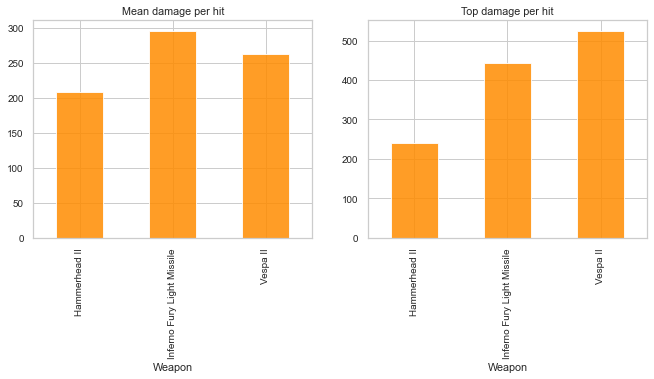

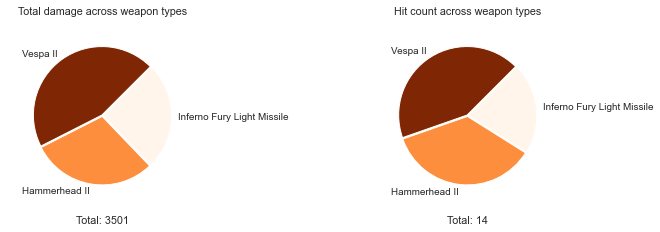

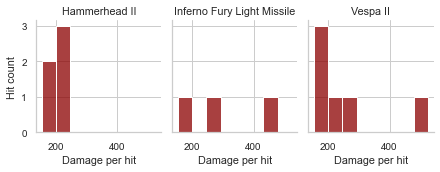



Performance on EoM Warp Disruptor Tower:



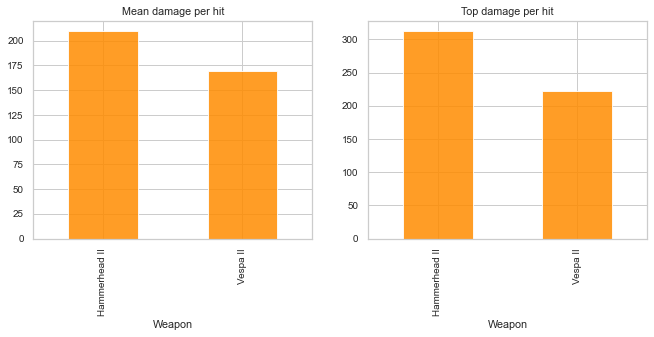

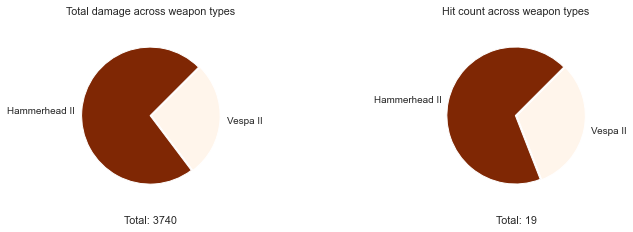

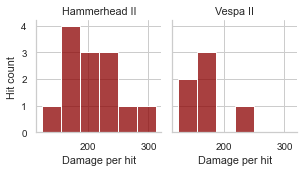



Performance on EoM Black Dagger:



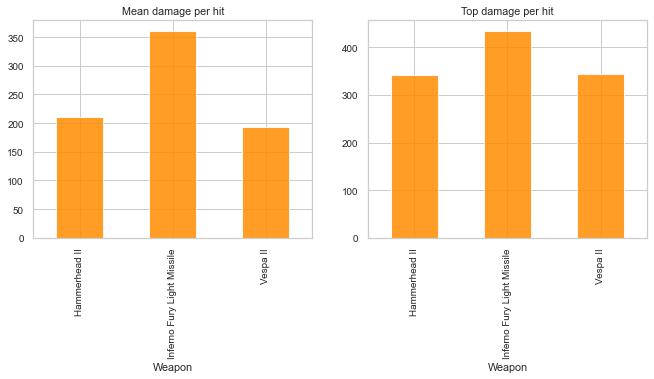

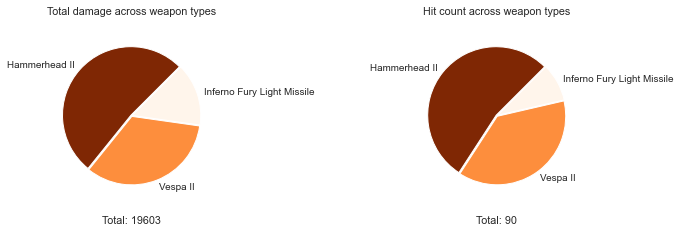

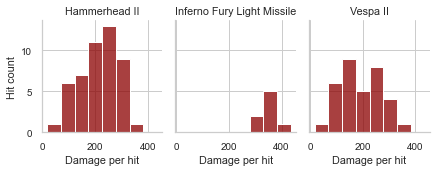



Performance on EoM Holy Sanctifier:



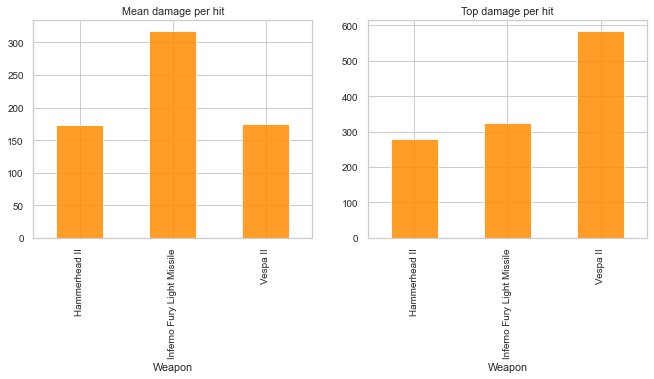

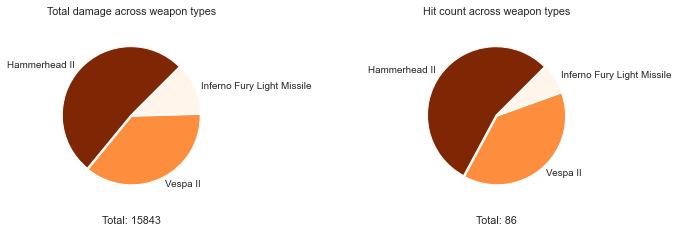

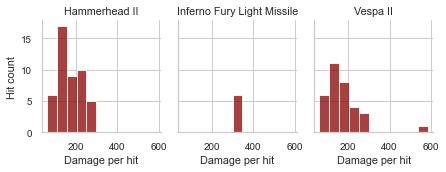



Performance on EoM Devout Fanatic:



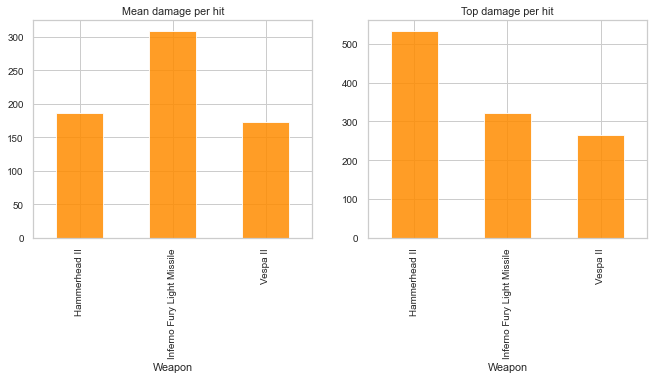

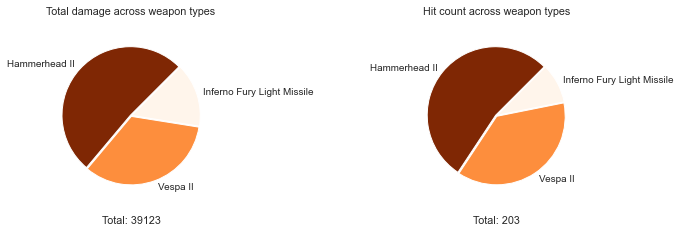

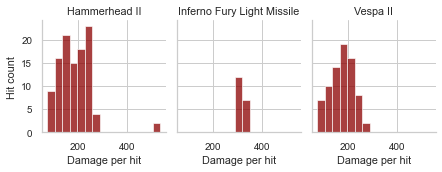



Performance on EoM Hoplokrisma:



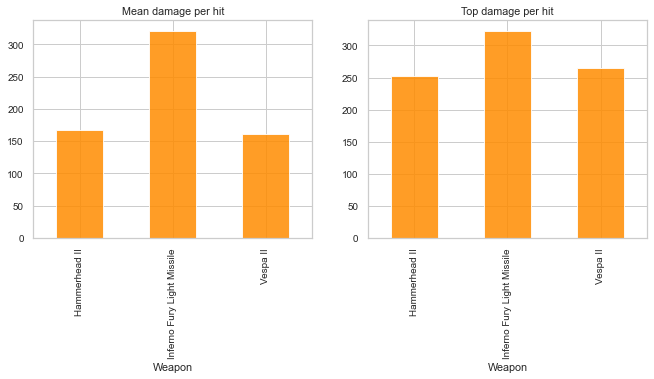

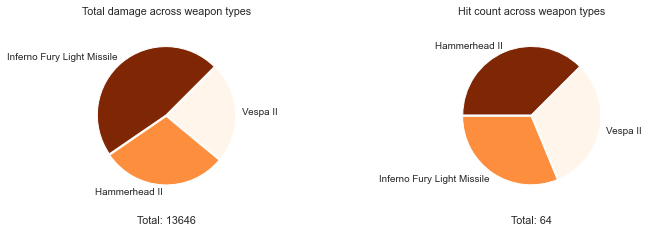

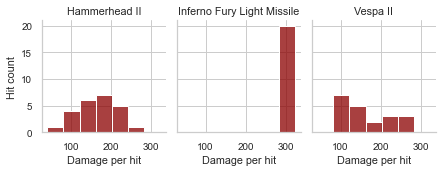



Performance on EoM Holy Purger:



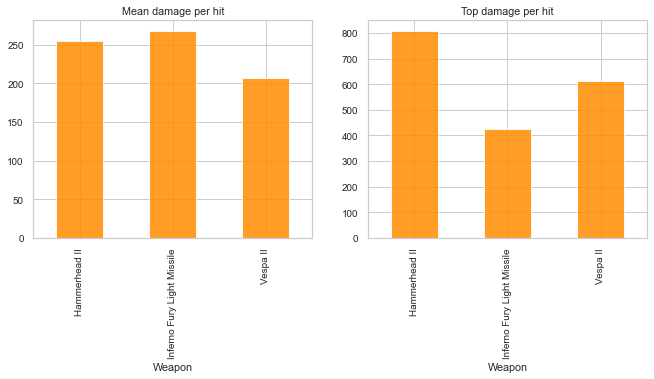

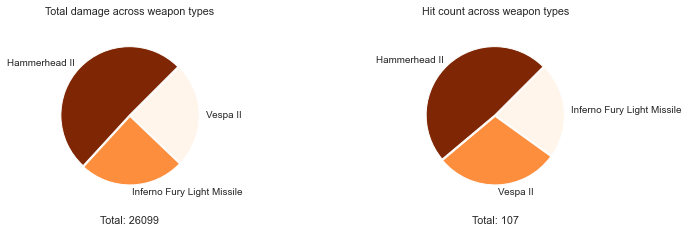

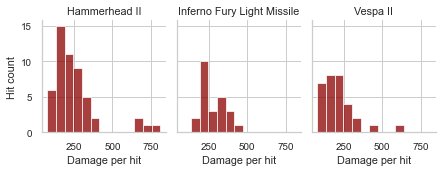



Performance on EoM Holy Binder:



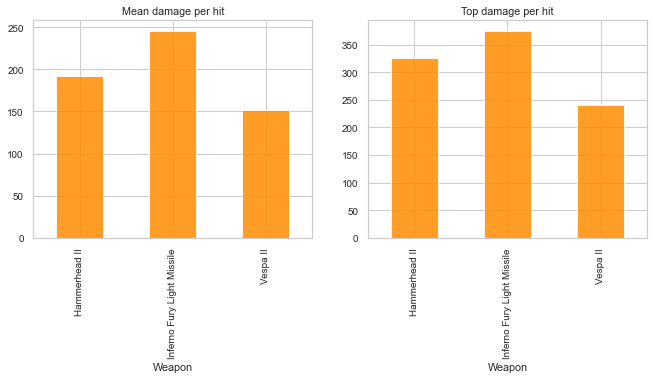

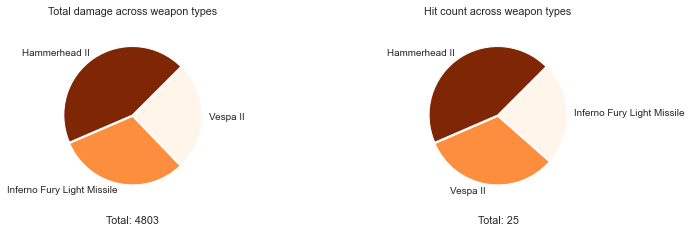

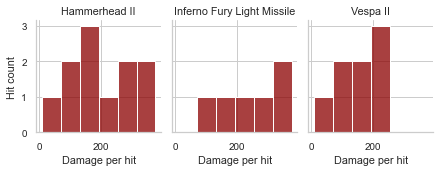



Performance on EoM Zealous Sword:



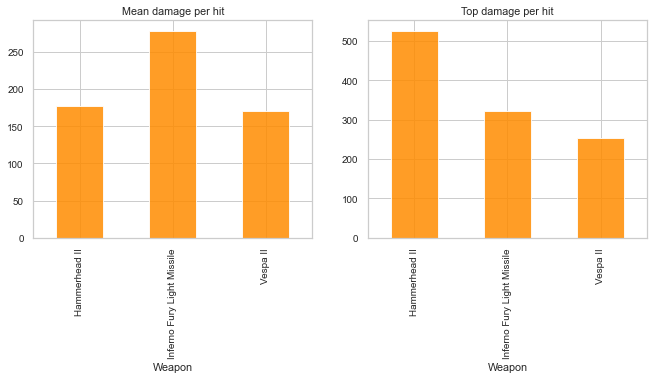

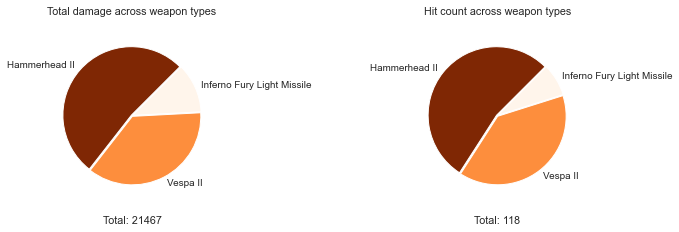

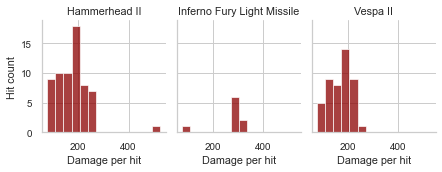



Performance on EoM Atoning Warrior:



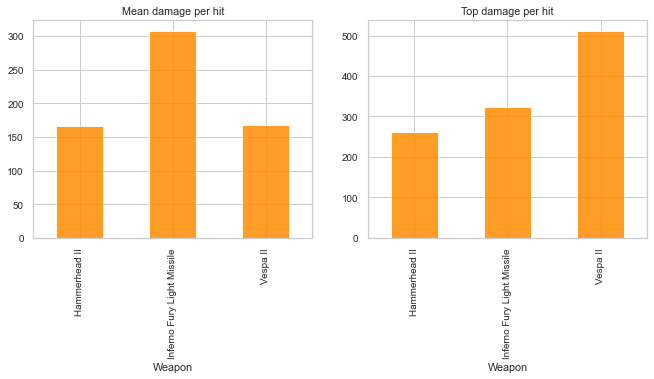

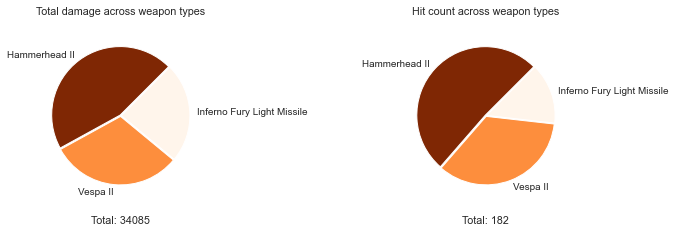

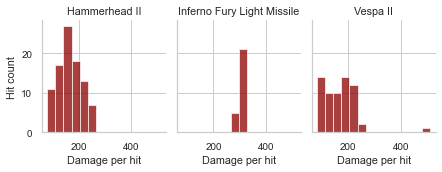



Performance on Vulnerable EoM Rogue Capital Shipyard:



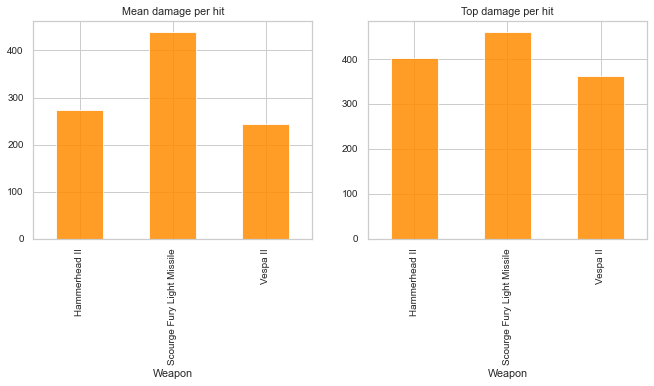

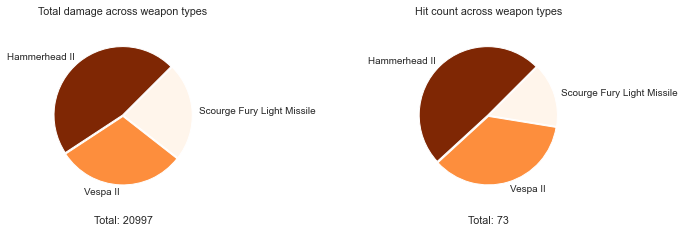

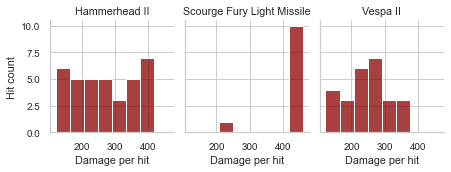

In [125]:
for target in targets:
    print(f'\nPerformance on {target}:', end='\n'*2)
    
    data_slice = dealt_df[dealt_df.Entity == target].sort_values(by='Weapon')
    
    if sum(totals_per_weapon) > 0:
        
        # mean and top damage barcharts
        plt.figure(figsize=(11,4)) 
        
        plt.subplot(121) #  plotting mean damage per hit per weapon 
        data_slice.groupby('Weapon').Damage.mean().plot(
            kind='bar', title='Mean damage per hit',
            ylabel='', 
            color='darkorange', alpha=.85
        )
        plt.subplot(122) #  plotting top damage per hit per weapon 
        data_slice.groupby('Weapon').Damage.max().plot(
            kind='bar', title='Top damage per hit', ylabel='', 
            color='darkorange', alpha=.85
        )      
        
        plt.show()
        
        # total damage and hit count pies
        totals_per_weapon = data_slice.groupby('Weapon').Damage.sum().sort_values(ascending=False)
        hits_per_weapon = data_slice.Weapon.value_counts().sort_values(ascending=False)
        
        plt.figure(figsize=(12,3.5), facecolor='white') 

        plt.subplot(121, #  plotting total damage across weapon types
                    xlabel=f'Total: {sum(totals_per_weapon)}')
        totals_per_weapon.plot(
            kind='pie', title='Total damage across weapon types',
            radius=.9,
            # center=(0,-5),
            cmap='Oranges_r',
            ylabel='', 
            startangle = 45,
            explode = pie_exploder(totals_per_weapon)
        )
        plt.subplot(122, #  plotting hit counts per weapon
                    xlabel=f'Total: {sum(hits_per_weapon)}') 
        hits_per_weapon.plot(
            kind='pie', title='Hit count across weapon types', ylabel='',
            cmap='Oranges_r',
            radius=.9,
            startangle = 45,
            explode = pie_exploder(hits_per_weapon)
        )        
        
        plt.show()
        
        # damage per hit distributions across weapon systems
        g = sns.displot(
            data=data_slice, x="Damage", col="Weapon",
            col_wrap=5,
            height=2.5, aspect=.8, color='darkred'
        )
        g.set_axis_labels("Damage per hit", "Hit count")
        g.set_titles("{col_name}")
        plt.show()
        
        print()

    else:
        print('- Zero damage scored', end='\n'*2)
        continue